# Final Assignment

In this assignment, you will build a relation extraction model for scientific articles based on the [ScienceIE dataset](https://scienceie.github.io/) in a group of up to 3 students. This is the same dataset that was used for Assignment 2, where you had to train a model to extract keyphrases. You are welcome to build on code any team member already wrote for Assignment 2.

You will build and train relation extraction models on the ScienceIE dataset. For this, you will also need to do data preprocessing to convert the ScienceIE data into a format suitable for training a relation extraction models. 

Your mark will depend on:

* your **reasoning behind modelling choices** made
* the correct **implementations** of your relation extraction models, and
* the **performance** of your models on a held-out test set.

To develop your model you have access to:

* The data in `data/scienceie/`. Remember to un-tar the data.tar.gz file.
* Libraries on the [docker image](https://cloud.docker.com/repository/docker/bjerva/stat-nlp-book) which contains everything in [this image](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook), including scikit-learn, torch 1.2.0 and tensorflow 1.14.0. 


As with the previous assignment, since we have to run the notebooks of all students, and because writing efficient code is important, your notebook should run in 10 minutes at most, including package loading time, on your machine.
Furthermore, you are welcome to provide a saved version of your model with loading code. In this case loading, testing, and evaluation has to be done in 10 minutes. You can use the dev set to check if this is the case, and assume that it will be fine for the held-out test set if so.

## Setup Instructions
It is important that this file is placed in the **correct directory**. It will not run otherwise. The correct directory is

    DIRECTORY_OF_YOUR_BOOK/assignments/2019/final_assignment/problem/
    
where `DIRECTORY_OF_YOUR_BOOK` is a placeholder for the directory you downloaded the book to. After you placed it there, **rename the file** to your UCPH ID (of the form `xxxxxx`). 

## General Instructions
This notebook will be used by you to provide your solution, and by us to both assess your solution and enter your marks. It contains three types of sections:

1. **Setup** Sections: these sections set up code and resources for assessment. **Do not edit these**. 
2. **Assessment** Sections: these sections are used for both evaluating the output of your code, and for markers to enter their marks. **Do not edit these**. 
3. **Task** Sections: these sections require your solutions. They may contain stub code, and you are expected to edit this code. For free text answers simply edit the markdown field.  

Note that you are free to **create additional notebook cells** within a task section. 

**Do not share** this assignment publicly, by uploading it online, emailing it to friends etc. 

**Do not** copy code from the Web or from other students, this will count as plagiarism.

## Submission Instructions

To submit your solution:

* Make sure that your solution is fully contained in this notebook. 
* **Rename this notebook to your UCPH ID** (of the form "xxxxxx"), if you have not already done so.
* Download the notebook in Jupyter via *File -> Download as -> Notebook (.ipynb)*.
* Upload the notebook to Absalon.


## <font color='green'>Setup 1</font>: Load Libraries
This cell loads libraries important for evaluation and assessment of your model. **Do not change it.**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#! SETUP 1
import sys, os
_snlp_book_dir = "../../../../"
sys.path.append(_snlp_book_dir) 
import math
from glob import glob
from os.path import isfile, join
from statnlpbook.vocab import Vocab
from statnlpbook.scienceie import calculateMeasures
import shutil
import string

## <font color='blue'>Task 1</font>: Convert dataset between standoff and IOB format

We want to work with [the ScienceIE dataset](https://scienceie.github.io) that can be found in the `data/scienceie/` directory of the repository.  This dataset comes with **standoff annotation** for keyphrases and relations between them.  This means that for each document in the dataset, there are two files: a `.txt` file with the raw sentences, and a `.ann` file with the annotated keyphrases.  

For example, this is one of the `.txt` files from the training set:

```
Failure of structural components is a major concern in the nuclear power industry and represents not only a safety issue, but also a hazard to economic performance. Stress corrosion cracking (SCC), and especially intergranular stress corrosion cracking (IGSCC), have proved to be a significant potential cause of failures in the nuclear industry in materials such as Alloy 600 (74% Ni, 16% Cr and 8% Fe) and stainless steels, especially in Pressurised Water Reactors (PWR) [1–5]. Stress corrosion cracking in pressurized water reactors (PWSCC) occurs in Alloy 600 in safety critical components, such as steam generator tubes, heater sleeves, pressurized instrument penetrations and control rod drive mechanisms [2,6,7]. Understanding the mechanisms that control SCC in this alloy will allow for continued extensions of life in current plant as well as safer designs of future nuclear reactors.
```

And this is the corresponding `.ann` file:

```
T1	Material 11 32	structural components
T2	Process 0 32	Failure of structural components
T3	Process 254 259	IGSCC
T4	Process 213 252	intergranular stress corrosion cracking
*	Synonym-of T4 T3
T5	Process 165 190	Stress corrosion cracking
T6	Process 192 195	SCC
*	Synonym-of T5 T6
T7	Material 367 376	Alloy 600
T8	Material 378 402	74% Ni, 16% Cr and 8% Fe
*	Synonym-of T7 T8
T9	Material 408 424	stainless steels
T10	Material 440 466	Pressurised Water Reactors
T11	Material 468 471	PWR
T12	Process 480 505	Stress corrosion cracking
T13	Material 509 535	pressurized water reactors
T14	Material 537 542	PWSCC
*	Synonym-of T13 T14
T15	Material 554 563	Alloy 600
T16	Material 603 624	steam generator tubes
T17	Material 626 640	heater sleeves
T18	Material 642 677	pressurized instrument penetrations
T19	Material 682 710	control rod drive mechanisms
T20	Material 762 765	SCC
T21	Material 774 779	alloy
T22	Material 835 840	plant
T23	Task 852 892	safer designs of future nuclear reactors
T24	Material 876 892	nuclear reactors
T25	Material 567 593	safety critical components
R1	Hyponym-of Arg1:T16 Arg2:T25	
R2	Hyponym-of Arg1:T17 Arg2:T25	
R3	Hyponym-of Arg1:T18 Arg2:T25	
R4	Hyponym-of Arg1:T19 Arg2:T25
```

Note: Besides keyphrases, which you are already familiar with from Assignment 2, the `.ann` files also contain relation annotations labeled `Hyponym-of` and `Synonym-of`. These are relations between keyphrases. 

`Synonym-of` is an undirected relation, meaning that if you see a line like this:

```*	Synonym-of T13 T14```

The order of keyphrases could be swapped, i.e. the following would also hold:

```*	Synonym-of T14 T13```

The evaluation script will thus be agnostic to the order in which the keyphrases between which `Synonym-of` relations hold are ordered.

`Hyponym-of`, on the other hand, is a directed relation, meaning that it is order-sensitive, and that the evaluation script will take the order of keyphrases between which `Hyponym-of` relations hold into account.

The `.ann` standoff format is **documented in [the brat documentation](http://brat.nlplab.org/standoff.html).**  
You may want to convert the format into some internal representation for training models; however, how you do that is up to you, i.e. you do not have to use IOB format like in Assignment 2. 

**Further Notes**:
- At training time, you you will be provided with plain text documents and `.ann` files with keyphrases and relations
- At test time, you will be provided with plain text documents and `.ann` files **with keyphrases only**. This is because your task is to predict relations.
- The evaluation script is agnostic to the order of relation triples and relation ids, but should preserve the ids of the keyphrases that will be used in the predicted relations. The evaluation scripts requres the entity annotations to be present as well in the prediction file.

## <font color='blue'>Task 1.1</font>: Develop and Train a Relation Extraction Model with Gold Keyphrases

In this task, you develop a relation extraction model and apply it to the ScienceIE dataset.
As input to it, at test time, you will have the plain input texts as well as `.ann` files containing gold (i.e. correct) keyphrase annotations. The output should be `.ann` files containing relations between those keyphrases (you should include the keyphrase annotations in the output file as well).

A test input/output example is given in folders `data/scienceie/test/`,`data/scienceie/test_pred/`.

There are no strict requirements for how to design this model. You are expected to use the knowledge you have gathered throughout this course to design and implement this model. 

You are welcome to re-use existing code you might have written for other assignments as you see fit.

You are free to implement your solution in either PyTorch or Tensorflow, but if you are not sure where to start, we recommend looking at the [Keras API](https://keras.io) which is [integrated into Tensorflow 1.14.0](https://www.tensorflow.org/beta/guide/keras/overview?hl=en).

### Module imports

To highlight the important parts of the assignmen, most of the functions are written in modules in 'Extra_files/modules'. These are imported below.

In [3]:
### General modules
import pprint
from gensim.models import fasttext
from gensim.models import KeyedVectors
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from pickle import load, dump
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Concatenate, Conv1D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy  # , sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
pp = pprint.PrettyPrinter(compact = True).pprint


### Our own modules
from Extra_files.modules.load_and_save import load_scienceie, save_to_ann, reformat_to_save
from Extra_files.modules.rules import _add_rules
from Extra_files.modules.error_analysis import plot_confusion_matrix, get_dataframe, plot_correct_labels
from Extra_files.modules.DataPreparation import entityLocator, addPOStoDic, addLemmatoDic, inputPair
from Extra_files.modules.WordEmbedder import WordEmbedder
from Extra_files.modules.MasterVocab import MasterVocab
from Extra_files.modules.scaling import downscale, upscale
from Extra_files.models.dummy_model import _sebastians_dummy_model
from Extra_files.modules.DataSeq import trainable_emb
from Extra_files.modules.helpers import f1_score_ala_calc_measures
from Extra_files.modules.Dynamic_pooling import Dynamic_max_pooling
from Extra_files.models.fasttext_cnn2 import fasttext_cnn_model
from Extra_files.models.fasttext_cnn_UMLS import fasttext_cnn_UMLS_model


# Data pre-processing

To identify relations between entities, the input data goes through several preprocessing steps:

##### Conversion to IOB format
First, the .ann and .txt files are converted to IOB format, as we need to identify the entities and the sentences between these for the later modelling. In this conversion, several entites have to be removed, as entities overlap. In this case, the longest entities have been kept. This also leads to a slight loss in the number of relations, as some of these referes to entities, which are removed due to overlap.

##### Removing references
Several texts have references. In most cases however, these do not add any value to the understanding, and this thus only noise for our model. Furthermore, references are often in the sentence between hyponyms and hypernyms. An example, where the references can complicate the relation detection can be seen in the first row below, where a reference is in between the entities.

##### Concatenating 'e.g.' and 'i.e.'
Multiple entities with relations a mentioned with 'XXXX, e.g. YYYY' and 'XXXX, i.e. YYYY'. An example of both of these cases can be seen in line 2 and 3 in the table below. If the tokens are split as 'e', '.', 'g' and '.', it may very well be more difficult for the model to learn, than if it is a single token.
<br>

<img src="Extra_files/figures/Filter_examples.png">

#### Transformation to model input
To train the model, every entity-pair, and the sentence between these are extracted. This gives us $\frac{n_i \cdot (n_i-1)}{2}$ data points per file (where $n_i$ is the number of entities in the file).

#### Downscaling
With the format as above, the dataset is severely imbalanced with 99% of the entities having no relation. This would make it almost impossible for the model to train. Therefore for all entities mentioned in different sentences, no relationship is assumed, and these datapoints are removed. This reduces the size of that data sets with roughly 80%, and in the train data, this corresponds to removing 45785 data points with no relations and while only catching 5 datapoints with a relation.

#### Upscaling
As the dataset after imbalance is still significantly biased (with ~95% of datapoints having no relations), the datapoints with relations is artificially upscaled with a factor 10. This will hopefully get the model to learn the features for relations faster. The upscaling will naturally only be done on the training set, and the development set will then be used to rescale the probabilities again. <br>
The distribution of the labels before downscaling, after downscaling and after upscaling of relations can be seen in the figure below.




<img src="Extra_files/figures/Label_dist.png">


## Load_scienceie
This function handles the three first preprocessing steps:
- IOB conversion
- Removing references
- Concatinating 'e.g.' and 'i.e.'

In [4]:
print("Loading dev_data...")
dev_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))
print("Loading train_data...")
train_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))

Loading dev_data...
Number of entities removed due to overlap: 269 out of 1330
Number of entities not identified in text: 1 out of 1061
Number of relations lost due to overlap: 10 out of 168
Removed references.
Concatenated 'i.e.' and 'e.g.'.
Loading train_data...
Number of entities removed due to overlap: 1337 out of 7405
Number of entities not identified in text: 28 out of 6068
Number of relations lost due to overlap: 50 out of 673
Removed references.
Concatenated 'i.e.' and 'e.g.'.


### Spacy

After scaling, we will add POS-tagging and lemmatizations. For this, we will use Spacy's model 'en', so it is downloaded below:

In [5]:
!python -m spacy download en
nlp = spacy.load("en")
nlp.tokenizer = nlp.tokenizer.tokens_from_list

     |████████████████████████████████| 11.1MB 1.1MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp36-none-any.whl size=11075236 sha256=4adff1015bbf6fdbf5310061878f03e1f54b4da61c31b29320c7c5ffac415f43
  Stored in directory: /tmp/pip-ephem-wheel-cache-8e2vj82_/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


### Transform to indices

For the model, we will need the POS tags and IOB labels to be transformed into indices. For this our own version of the 'Vocab' class from 'statnlpbook.vocab' has been created. This is simply imported below, but in the 'if False' statement, the code which is originally run can be seen.

In [6]:
# Generate the Vocab classes. 
if True:
    vocab = load(open('Extra_files/resources/vocab.pkl', 'rb'))
if False:
    vocab = MasterVocab(max_vocab_size = 4092)
    vocab.generateVocabularies(train_data, nlp_language)
    dump(vocab, open('Extra_files/resources/vocab.pkl', 'wb'))

### Model for FastText embedding

The words and lemmas are embedded with FastText. Embedding with the pretrained KeyedVectors however, gives a 300 long vector. This is feared to give too many parameters however, which both takes a long time to train and with a higher risk of overfitting. To remedy this, a PCA has been performed on the FastText embeddings in order to decrease the vector size without and still keeping the maximal distance between the different vectors in the space, so these can still be separated.

In [7]:
## Load the English Embedder and PCA
engbedder = WordEmbedder()
engbedder.loadEmbedder()

PCA model loaded from Extra_files/resources/PCA.pkl


The Figure below shows the full preprocessing procedure: <br>

<img src="Extra_files/figures/Preprocessing.png">


### The function 'dataX_Y_format'
The function below handles:
- Reshaping to train data format
- Downscaling
- Upscaling train data
- Adding lemmas
- Adding POS
- Adding Principal Components of FastText embeddings

In [13]:
### I have split the functions but made it backwards compatible
def dataX_Y_format(data, indices = False, embeddings = False, embedder = engbedder):
    data_m_XY = dataX_Y_format_no_index(data)
    data_m_XY = downscale(data_m_XY)
#     data_m_XY = upscale(data_m_XY) # Only for train
        
    if indices or embeddings:
        if embeddings:
            data_m_XY = transform_to_embeddings(data_m_XY, embedder)
        else:
            data_m_XY = transform_to_indices(data_m_XY)
        #end-if
    return data_m_XY

# Only without index
def dataX_Y_format_no_index(data, nlp_language = nlp):
    
    metadata = []
    data_X = []
    data_Y = []
        
    for txt, file in data.items():
        addPOStoDic(file, nlp_language)
        addLemmatoDic(file, nlp_language)
        entities = entityLocator(file)
        
        #Labels
        labels = {}
        labels['Synonyms']= [(rel[2],rel[3]) for rel in file['relations'] if rel[1] == 'Synonym']
        labels['Hyponyms'] = [(rel[2],rel[3]) for rel in file['relations'] if rel[1] == 'Hyponym']
        
        # create a 'stair' of combinations
        
        for i in range(len(entities)):
            for j in range(i+1, len(entities)):
                
                #Extrac X and annotation names
                ann_names = (entities[i][0],entities[j][0])
                ann_names_reverted = (entities[j][0],entities[i][0])
                
                metadata.append( (txt,entities[i][0],entities[j][0]))
                
                xdata = inputPair(entities[i], entities[j], file, nlp_language)
                data_X.append(np.array(xdata))
                
                ### Extract label
                if ann_names in labels['Hyponyms']:
                    data_Y.append('Hyponym')
                elif ann_names_reverted in labels['Hyponyms']:
                    data_Y.append('Hypernym')
                elif ann_names in labels['Synonyms'] or ann_names_reverted in labels['Synonyms']:
                    data_Y.append('Synonym')
                else:
                    data_Y.append('NONE')
                    

    #We need it all in a single object
    data = {'metadata': metadata, 'data_X': data_X, 'data_Y': data_Y, 'Vocab': vocab}
    
    return data

#Transform to indices
def transform_to_indices(data_m_XY):
    '''
    Inplace transform of words to indices
    
    Uses 'vocab' from global env.
    '''
    for idx in range(len(data_m_XY['data_Y'])):
        data_m_XY['data_X'][idx] = vocab.transformX_toIndex(data_m_XY['data_X'][idx]) 
    
    return data_m_XY

# Transform to Embeddings & indices
def transform_to_embeddings(data_m_XY, embedder):
    '''
    Inplace transform of words to embeddings and indices
    
    Uses 'vocab' from global env.
    '''
    for idx in range(len(data_m_XY['data_Y'])):
        data_m_XY['data_X'][idx] = vocab.transformX_toEmbeddings(data_m_XY['data_X'][idx], embedder) 
    
    return data_m_XY

#### Load pre-transformed data
The function above takes too long time to run (appr. 10min). The code below reloads the transformed data, while the 'if False' statement contains the original code.

In [14]:
if True:
    data_m_XY_dev = load(open('Extra_files/resources/dev_emb.pkl', 'rb'))

    
    dev_X = data_m_XY_dev['data_X']
    dev_Y = data_m_XY_dev['data_Y']
#     train_X = data_m_XY['data_X']
#     train_Y = data_m_XY['data_Y']
if False:
#     data_m_XY = load(open('Extra_files/resources/train_emb_up10.pkl', 'rb'))
    
    data_m_XY = dataX_Y_format(train_data,indices = True) 
    dump(data_m_XY, open('Extra_files/resources/train_emb.pkl', 'wb'))
    data_m_XY_dev = dataX_Y_format(dev_data, embeddings = True)
    dump(data_m_XY_dev, open('Extra_files/resources/dev_emb.pkl', 'wb'))
    
    train_X = data_m_XY['data_X']
    train_Y = data_m_XY['data_Y']

##### Mathias' model, I will not touch

In [19]:
## MW - QUICK MODEL - NEEDED GLOBAL VARIABLES 

# DON'T TOUCH, WILL BE MOVED / CLEANED

enc = OneHotEncoder()
### NfS
# enc.fit(np.asarray(data_m_XY['data_Y']).reshape(-1,1))
enc.fit(np.asarray(['Hyponym', 'Hypernym', 'NONE', 'Synonym']).reshape(-1,1))
###

def pre_embedded(enc, xs, ys=None, once=False, UMLS=None):
    """
    Catch all function:
        makes data trainable/predictable by yielding batches of single observations, i.e.
        compatable with the input of the NN
    """

    def to_col_list(sequence):
        return [np.expand_dims(x, 0) if i in [3, 4] else np.expand_dims(np.expand_dims(x, -1), 0) if i in [1,2] else np.expand_dims(np.stack(x), 0) for i, x in
                    enumerate(list(np.swapaxes(sequence, 1, 0)))]
    def onehot(y):
        return enc.transform(np.array(y).reshape(-1, 1)).todense()

    if ys is not None and UMLS is None:
        while True:
            for x, y in zip(xs, ys):
                yield to_col_list(x), onehot(y)
            if once:
                break
                
    elif ys is None and UMLS is None:
        while True:
            for x in xs:
                yield to_col_list(x)
            if once:
                break
    else:
        while True:
            tmp = list(sorted(set(UMLS)))  # convert to index
            for x, y, u in zip(xs, ys, UMLS):
                out_x = to_col_list(x)
                out_x.append(np.expand_dims(np.asarray([tmp.index(u)]),0))
                yield out_x, onehot(y)
            if once:
                break


class keras_seq(Sequence):

    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]


def to_tf_format(enc, xs, ys, UMLS=None):
    return keras_seq(list(pre_embedded(enc, xs, ys, True, UMLS)))

In [24]:
train_keys = set(train_data.keys())
dev_keys = set(dev_data.keys())

def cached_data_formatter(data, UMLS=False):
    """
    Load formatted data for train and dev
    else, outputs formatted data (incl metadata), and a tensorflow-friendly format
    """
    if set(data.keys())== train_keys:
        if not UMLS:
            return data_m_XY, trainable_emb(train=True, up=10)
        else:
            return data_m_XY, trainable_emb(train=True, UMLS=True)
        
    elif set(data.keys())== dev_keys:
        if not UMLS:
            return data_m_XY_dev,  trainable_emb(train=False)
        else:
            return data_m_XY_dev, trainable_emb(train=False, UMLS=True)
    else:
        full_formatted = dataX_Y_format(data, embeddings=True)
        if UMLS:
            UMLS = []
            data_m_XY2 = dataX_Y_format(data, indices = False) 
            data_m_XY2 = add_UMLS(data_m_XY2)
            tmp = [str(x) for x in data_m_XY2['metadata']]
            tmp2 = data_m_XY2['UMLS']
            for i, met in enumerate(full_formatted['metadata']):
                idx = tmp.index(str(tuple(met)))
                UMLS.append(tmp2[idx])
#                 trainable_UMLS = list(pre_embedded(enc, train_X, train_Y, True, UMLS))
            place_holder_Y = [None]*len(full_formatted['data_X'])
            return full_formatted, to_tf_format(enc, full_formatted['data_X'],  place_holder_Y, UMLS)
#         if 'data_Y' in full_formatted.keys():
#             return full_formatted, to_tf_format(enc, full_formatted['data_X'],  full_formatted['data_Y'], UMLS)

In [22]:
# You should improve this cell

def create_model(train_data, dev_data):
    """
    Return an instance of a relation extraction model defined over the dataset.
    Args:
        train_data: the training data the relation extraction detection model should be defined over.
        dev_data: the development data the relation extraction detection model can be tuned on.
    Returns:
        a relation extraction model
    """
    
    if True:
        return fasttext_cnn_model()
    
    else:
        ## PARAMETERS

        # Embeddings
        entity_vocab_size = 20
        pos_vocab_size = 20

        # word_emb_dim = 50
        entity_emb_dim = 10
        pos_emb_dim = 10

        # Conv1D
        filters = 200
        conv_kernel_size = 1
        conv_strides = 1

        # Pooling
        dyn_out_len = 100

        ## LAYERS

        # Input
        tokens = Input(batch_shape=(1, None, 51))
        relpos1 = Input(batch_shape=(1, None, 1))
        relpos2 = Input(batch_shape=(1, None, 1))
        entity = Input(batch_shape=(1, None))
        pos = Input(batch_shape=(1, None))
        lemma = Input(batch_shape=(1, None, 51))

        # Embedding
        entity_emb = Embedding(entity_vocab_size, entity_emb_dim)(entity)
        pos_emb = Embedding(pos_vocab_size, pos_emb_dim)(pos)

        # Base-model
        x = Concatenate(axis=2)([tokens, relpos1, relpos2, entity_emb, pos_emb, lemma])
        x = Dropout(0.5)(x)
        x = Conv1D(filters=filters, kernel_size=conv_kernel_size, strides=conv_strides, padding='same', activation='relu')(x)
        x = Dynamic_max_pooling(filters, dyn_out_len)(x)
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = Dense(4, activation='softmax')(x)  # 4 == n_classes in data (i.e. NOT a parameter)

        ## Create model
        model = Model(inputs=[tokens, relpos1, relpos2, entity, pos, lemma], outputs=x)

        model.compile(loss=categorical_crossentropy,  # for onehot, for idx: sparse_categorical_crossentropy
                      optimizer=Adam(),
                      metrics=['accuracy'])

        return model

def train_model(model, train_data, dev_data):
    """Train a relation extraction model on the given dataset.
    Args:
        model: The model to train
        data_train: The dataset to train on
        dev_data: the development data the relation extraction detection model can be tuned on
    """
    

    
    if True:
        # Load pre-trained
        filters = 200
        dyn_out_len = 100
        path = os.path.join(os.getcwd(),'Extra_files/resources/fasttext_cnn_model_{}_{}/'.format(filters, dyn_out_len))
        path = os.path.join(path, list(os.listdir(path))[0], 'final_save')
        model.model.load_weights(path)
    else:
        callbacks = [ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=True),
                    EarlyStopping(patience=15, restore_best_weights=True)]

        train_set = to_tf_format(enc, train_X, train_Y)
        dev_set = to_tf_format(enc, dev_X, dev_Y) 
        epochs = 100
        model.model.fit_generator(generator=train_set, steps_per_epoch=len(train_set), epochs=epochs,
                              callbacks=model.training_callbacks(), verbose=1,
                              validation_data=dev_set, validation_steps=len(dev_set),
                              max_queue_size=100, workers=8, use_multiprocessing=True)

        
    
    return

def make_predictions(model, data, return_raw = False, threshold=0.45):
    """Makes predictions on a list of instances
    Args:
        model: The trained model
        data: The dataset to evaluate on
    Returns:
        The model's predictions for the data.
        If 'return_raw = True, it returns 'data_dict' (see below), else it returns reformatted data ready for saving.
    """
    
    
    local_data_m_XY, tf_formatted = cached_data_formatter(data)
    raw_preds = model.model.predict_generator(tf_formatted, workers=8, use_multiprocessing=True)  # probs
    if threshold is not None:
        raw_preds[:,2] += threshold
        
    predictions = list(np.squeeze(enc.inverse_transform(raw_preds)))  # human-readable

    ### Save in correct format
    local_data_m_XY['data_Y'] = predictions
    if return_raw:
        return local_data_m_XY
    else:
        #data = deepcopy(data)   ##### DOES NOT WORK ATM - USING GLOBAL VARS
        save_format = reformat_to_save(local_data_m_XY)
        for txt in data:
            data[txt]['relations'] = save_format.get(txt,[]) #We might have txt's with no data after downscaling

        return data


In [13]:
# Create model
model = create_model(train_data, dev_data)
train_model(model, train_data, dev_data)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Rescaling the probabilities

As we upscaled the number of relations during training, the model learned a different label distribution than the correct. To account for this, we will in the prediction fase add a probability to the `NONE` label, which will correspond to subtracting from the three other labels.

The optimal addition will be determined by tuning on the Micro F1-score, which is the score that will be used in the final evaluation. The result can be seen below.

<img src="Extra_files/figures/F1_tuning.png">

We see, that if we add 45% to the `NONE` label before choosing the label with highest probability, we will maximize the f1-score and get around 40%.

### Confusion matrices

To investigate the accuracy within each group, we plot the confusion matrices both before and after the threshold tuning:

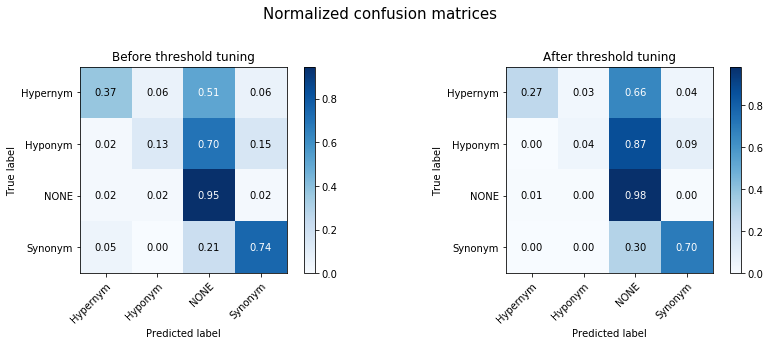

F1-score before tuning: 35.69%
F1-score after tuning: 40.0%


In [46]:
#Make predictions
y_no_tune = make_predictions(model, dev_data, return_raw = True, threshold=None)['data_Y']
y_w_tune = make_predictions(model, dev_data, return_raw = True, threshold=0.45)['data_Y']
y_true = dev_Y

### Create plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,3.8))
fig.suptitle('Normalized confusion matrices',y=1.1,fontsize = 15)
ax1 = plot_confusion_matrix(y_true, y_no_tune, n_labels=None,normalize=True,ax = ax1)
ax1.set(title = 'Before threshold tuning')
ax2 = plot_confusion_matrix(y_true, y_w_tune, n_labels=None,normalize=True, ax = ax2)
ax2.set(title = 'After threshold tuning')
plt.show()

### Calculate F1 scores
f1_score_before = f1_score_ala_calc_measures(y_true, y_no_tune,printing = False)
f1_score_after = f1_score_ala_calc_measures(y_true, y_w_tune,printing = False)
print("F1-score before tuning: {}%".format(round(f1_score_before * 100,2)))
print("F1-score after tuning: {}%".format(round(f1_score_after * 100,2)))

We see, that we a better at guessing `Hypernym`, `Hyponym` and `Synonym` before threshold tuning. When we score with Micro F1 however, it is simply too costly, as we mislabel too many `NONE` as having a relation. Especially `Hyponym` seems very difficult to distinguish from `NONE`.

### The 'calculateMeasures' function on dev set

To ensure everything works as expected, we run the 'calculateMeasures' function on the dev set:

In [48]:
# Use this cell to test on the dev set
data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
dir_dev = join(_snlp_book_dir, "data", "scienceie", "dev")
data_dev = load_scienceie(datadir=dir_dev)

model = create_model(data_train, [])
train_model(model, data_train, [])

data_pred = make_predictions(model, data_dev)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "dev_pred")
save_to_ann(data_pred, dir_pred)

calculateMeasures(dir_dev, dir_pred, "keys") # this will only evaluate the correctness of relations

Number of entities removed due to overlap: 1337 out of 7405
Number of entities not identified in text: 28 out of 6068
Number of relations lost due to overlap: 50 out of 673
Removed references.
Concatenated 'i.e.' and 'e.g.'.
Number of entities removed due to overlap: 269 out of 1330
Number of entities not identified in text: 1 out of 1061
Number of relations lost due to overlap: 10 out of 168
Removed references.
Concatenated 'i.e.' and 'e.g.'.
           precision   recall f1-score  support

 Hyponym-of     0.14     0.05     0.07      123
 Synonym-of     0.43     0.73     0.55       45

avg / total     0.33     0.23     0.27      168




{'Hyponym-of': {'f1-score': 0.07228915662650602,
  'precision': 0.13953488372093023,
  'recall': 0.04878048780487805,
  'support': 123},
 'Synonym-of': {'f1-score': 0.5454545454545454,
  'precision': 0.4342105263157895,
  'recall': 0.7333333333333333,
  'support': 45},
 'overall': {'f1-score': 0.27177700348432055,
  'precision': 0.3277310924369748,
  'recall': 0.23214285714285715,
  'support': 168}}

In [ ]:
# DO NOT MODIFY THIS CELL! It will evaluate your model on an unseen dataset!
shutil.rmtree(join(_snlp_book_dir, "data", "scienceie", "test_pred")) # clean after previous

data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
data_dev = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))

model = create_model(data_train, data_dev)
train_model(model, data_train, data_dev)

data_test = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "test"))
data_pred = make_predictions(model, data_test)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "test_pred")
save_to_ann(data_pred, dir_pred)

dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")
calculateMeasures(dir_gold, dir_pred, "keys") # this will only evaluate the correctness of relations

## <font color='red'>Assessment 1.1</font>: Correctness of the implementation (20 pts)

We assess if your code implements a correct relation extraction model (10 points):

* 0-5 pts: the model does not run correctly or does not constitute a relation extraction model
* 5-10 pts: the model correctly implements the requirements

Additionally, we will assess how well your model performs on an unseen test set (10 points):

* 0-5 pts: performance worse than a simple baseline model
* 5-10 pts: performance better than a simple baseline model

## <font color='blue'>Task 1.2</font>: Describe your Approach

Enter a maximum 500 words description of your model developed in Task 1.1, its architecture, and the way you trained and tuned it. Motivate your choices, describing potential benefits and downsides.

## <font color='red'>Assessment 1.2</font>: Modelling Choices and Motivation (10 pts)


Finally, we assess your modelling design choices and how you motivated them, which you summarised in the above cell (10 points):

* 0-5 pts: the model design choices do not show high levels of creativity, e.g. re-using code from the lecture out of the box; and they are not moviated well
* 5-10 pts: the model design choices show high levels of creativity, e.g. combining different things learned throughout the course, models inspired by further reading, etc.; and they are motivated well

## <font color='blue'>Task 2</font>: Relation Extraction with Weak Supervision

In this task, the goal is to improve the performance of your model developed in Task 2 by obtaining more automatically labelled training data using a weak supervision approach. You are not required to change the relation extraction model architure, i.e. it is fine to re-use the one from Task 1, but instead, the requirements are to implement one or more weak supervision strategies.

Some possible weak supervision methods for relation extraction will be introduced in the lecture Week 43 (https://github.com/copenlu/stat-nlp-book/blob/master/chapters/relation_extraction_slides.ipynb); the following blog post also serves as a good introduction to this topic: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html

For this task, you are not confined to the training data provided to you, but you are welcome to obtain additional unlabelled datasets and automatically label them using weak supervision methods. 

The general setup will otherwise be the same as for Task 1:
As input to it, you will have the plain input texts as well as `.ann` files containing gold (i.e. correct) keyphrase annotations. The output should be `.ann` files containing relations between those keyphrases.

**Important notes**:
- You must provide code for the functions below. 
- If running them on the full dataset exceeds the 10 minute limit, you are welcome to additionally provide a line of code that (down)loads the already weakly annotated data.
- The maximum file size for weakly annotated data may not exceed 1GB.

A test input/output example is given in folders `data/scienceie/test/`,`data/scienceie/test_pred/`.

In [3]:
## Load Hypernyms from UMLS
from Extra_files.modules.UMLS import add_UMLS

# data_m_XY = add_UMLS(data_m_XY)

In [4]:
# data_m_XY2 = dataX_Y_format(train_data,indices = False) 
# data_m_XY2 = add_UMLS(data_m_XY2)
# tmp = [str(x) for x in data_m_XY2['metadata']]
# for i, met in enumerate(data_m_XY['metadata']):
#     if str(tuple(met)) not in tmp:
#         print(met,i)
#         break

In [5]:
# UMLS = []
# data_m_XY2 = dataX_Y_format(train_data,indices = False) 
# data_m_XY2 = add_UMLS(data_m_XY2)
# tmp2 = data_m_XY2['UMLS']
# for i, met in enumerate(data_m_XY['metadata']):
#     idx = tmp.index(str(tuple(met)))
#     UMLS.append(tmp2[idx])
# trainable_UMLS = list(pre_embedded(enc, train_X, train_Y, True, UMLS))
# print(set(UMLS))

In [6]:
# trainable_UMLS = load(open('Extra_files/resources/tf_train_UMLS.pkl', 'rb'))
# trainable_UMLS_dev = load(open('Extra_files/resources/tf_dev_UMLS.pkl', 'rb'))

<table>
  <tr>
    <th>Rule</th>
    <th>Format</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Abbreviations are synonyms</td>
    <td>XXXX (YYYY)</td>
    <td>If the entity in the parenthesis is an abbreviation (capital letters), <br>and there is an entity right in front of the parenthesis, let these be synonyms.</td>
  </tr>
  <tr>
    <td>Lists should have same relations</td>
    <td>XXXX, YYYY, ZZZZ<br>XXXX, YYYY and ZZZZ<br>XXXX, YYYY or ZZZZ</td>
    <td>Entities mentioned in a list can't have any relation to each other,<br> and are not Synonyms of anything. <br>If an entity has a Hyponym- or Hypernym-relation to an entity outside the list, <br>let them all have this relation.</td>
  </tr>
</table>

In [37]:
# You should improve this cell

def create_weak_model(train_data, dev_data, **args):
    """
    Return an instance of a relation extraction model defined over the dataset.
    Args:
        train_data: the training data the relation extraction detection model should be defined over.
        dev_data: the development data the relation extraction detection model can be tuned on.
        **args: any additional arguments needed, e.g. additional automatically labelled training data
    Returns:
        a relation extraction model
    """
    if True:
        return fasttext_cnn_UMLS_model()
    else:
         ## PARAMETERS

        # Embeddings
        entity_vocab_size = 20
        pos_vocab_size = 20

        entity_emb_dim = 10
        pos_emb_dim = 10

        # Conv1D
        conv_kernel_size = 1
        conv_strides = 1

        # Pooling

        ## LAYERS

        # Input
        tokens = Input(batch_shape=(1, None, 51))
        relpos1 = Input(batch_shape=(1, None, 1))
        relpos2 = Input(batch_shape=(1, None, 1))
        entity = Input(batch_shape=(1, None))
        pos = Input(batch_shape=(1, None))
        lemma = Input(batch_shape=(1, None, 51))

        UMLS = Input(batch_shape=(1, 1))

        # Embedding
        entity_emb = Embedding(entity_vocab_size, entity_emb_dim)(entity)
        pos_emb = Embedding(pos_vocab_size, pos_emb_dim)(pos)

        # Base-model
        x = Concatenate(axis=2)([tokens, relpos1, relpos2, entity_emb, pos_emb, lemma])
        x = Dropout(0.5)(x)
        x = Conv1D(filters=filters, kernel_size=conv_kernel_size, strides=conv_strides, activation='relu')(x)
        x = Dynamic_max_pooling(filters, dyn_out_len)(x)
        x = Flatten()(x)
        x = Concatenate(axis=1)([x, UMLS])  # ADD UMLS DIRECTLY TO DENSE INPUT
        x = Dropout(0.5)(x)
        x = Dense(4, activation='softmax')(x)  # 4 == n_classes in data (i.e. NOT a parameter)

        ## Create model
        model = Model(inputs=[tokens, relpos1, relpos2, entity, pos, lemma, UMLS], outputs=x)
        #     model.summary()

        model.compile(loss=categorical_crossentropy,  # for onehot, for idx: sparse_categorical_crossentropy
                      optimizer=Adam(),
                      metrics=['accuracy'])

        return model

def train_weak_model(model, train_data, dev_data, **args):
    """Train a relation extraction model on the given dataset.
    Args:
        model: The model to train
        data_train: The dataset to train on
        dev_data: the development data the relation extraction detection model can be tuned on
        **args: any additional arguments needed, e.g. additional automatically labelled training data
    """
    
    if True:
        # Load pre-trained
        filters = 200
        dyn_out_len = 100
        path = os.path.join(os.getcwd(),'Extra_files/resources/fasttext_cnn_UMLS_model_{}_{}/'.format(filters, dyn_out_len))
        path = os.path.join(path, list(os.listdir(path))[0], 'final_save')
        model.model.load_weights(path)
    else:
        train_set = trainable_emb(train=True, UMLS=True)  # load pickled
        dev_set = trainable_emb(train=False, UMLS=True)  # load pickled
        
        callbacks = [ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=True),
                    EarlyStopping(patience=15, restore_best_weights=True)]

        epochs = 100
        model.model.fit_generator(generator=train_set, steps_per_epoch=len(train_set), epochs=epochs,
                              callbacks=model.training_callbacks(), verbose=1,
                              validation_data=dev_set, validation_steps=len(dev_set),
                              max_queue_size=100, workers=8, use_multiprocessing=True)


def make_predictions_weak(model, data, return_raw = False, threshold = 0.45):
    """Makes predictions on a list of instances. Can be the same as function developed in Task 1.
    Args:
        model: The trained model
        data: The dataset to evaluate on
    Returns:
        The model's predictions for the data.
    """
    
    
    local_data_m_XY, tf_formatted = cached_data_formatter(data, UMLS=True)
    raw_preds = model.model.predict_generator(tf_formatted, workers=8, use_multiprocessing=True)  # probs
    if threshold is not None:
        raw_preds[:,2] += threshold
        
    predictions = list(np.squeeze(enc.inverse_transform(raw_preds)))  # human-readable
    local_data_m_XY['data_Y'] = predictions
#     local_data_m_XY = _add_rules(local_data_m_XY,data)
    
    if return_raw == True:
        return local_data_m_XY  
    else:
        save_format = reformat_to_save(local_data_m_XY)
        for txt in data:
            data[txt]['relations'] = save_format.get(txt,[]) #We might have txt's with no data after downscaling
        return data



In [38]:
# Create model
model = create_weak_model(train_data, dev_data)
train_weak_model(model, train_data, dev_data)


           precision   recall f1-score  support

    Hyponym     0.15     0.23     0.19       47
    Synonym     0.65     0.77     0.71       47
   Hypernym     0.16     0.30     0.21       67

avg / total     0.27     0.42     0.33      161




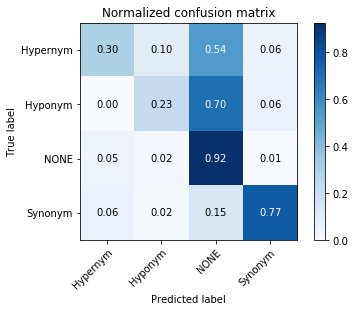

In [39]:
## THIS CELL TESTS THAT EVERYTHING WORKS AS EXPECTED (WITH F1-SCORE COPIED FROM CALCULATE-MEASURES) #####
from Extra_files.modules.helpers import f1_score_ala_calc_measures

#Make predictions
y_weak = make_predictions_weak(model, dev_data, return_raw = True, threshold=None)['data_Y']
y_true = dev_Y

#Plot
f1_score_ala_calc_measures(y_true, y_weak)
plot_confusion_matrix(y_true, y_weak, n_labels=None,normalize=True)
plt.show()

In [ ]:
# Training a model and evaluating it on the development set. 
# Use this to monitor the performance of your model prior to submitting your assignment.
data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
dir_dev = join(_snlp_book_dir, "data", "scienceie", "dev")
data_dev = load_scienceie(datadir=dir_dev)

model = create_weak_model(data_train, [data_dev])
train_weak_model(model, data_train, data_dev)

data_pred = make_predictions_weak(model, data_dev)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "dev_pred")
save_to_ann(data_pred, dir_pred)

calculateMeasures(dir_dev, dir_pred, "keys") 

In [ ]:
# DO NOT MODIFY THIS CELL! It will evaluate your model on an unseen dataset!
shutil.rmtree(join(_snlp_book_dir, "data", "scienceie", "test_pred")) # clean after previous

data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
data_dev = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))

model = create_weak_model(data_train, data_dev)
train_weak_model(model, data_train, data_dev)

data_test = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "test"))
data_pred = make_predictions_weak(model, data_test)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "test_pred")
save_to_ann(data_pred, dir_pred)

dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")
calculateMeasures(dir_gold, dir_pred, "keys") # this will only evaluate the correctness of relations

In [ ]:
dir_pred = join(_snlp_book_dir, "data", "scienceie", "test_pred")
dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")

dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")
calculateMeasures(dir_gold, dir_pred, "keys") # this will only evaluate the correctness of relations

## <font color='red'>Assessment 2.1</font>: Correctness of the implementation (20 pts)

We assess if your code implements correct weak supervision methods (10 points):

* 0-5 pts: the model does not run correctly or the methods implemented do not constitute weak supervision strategies
* 5-10 pts: the model correctly implements the requirements

Additionally, we will assess how well your model performs on an unseen test set (10 points):

* 0-5 pts: performance worse than a simple baseline model
* 5-10 pts: performance better than a simple baseline model

## <font color='blue'>Task 2.2</font>: Describe your Approach

Enter a maximum 500 words description of your weak supervision stategies developed in Task 2.1 and the way you trained and tuned them. Motivate your choices, describing potential benefits and downsides.

## <font color='red'>Assessment 2.2</font>: Modelling Choices and Motivation (10 pts)


Finally, we assess your modelling design choices and how you motivated them, which you summarised in the above cell (10 points):

* 0-5 pts: the model design choices do not show high levels of creativity, e.g. re-using code from the lecture out of the box; and they are not moviated well
* 5-10 pts: the model design choices show high levels of creativity, e.g. combining different things learned throughout the course, models inspired by further reading, etc.; and they are motivated well

## <font color='blue'>Task 3</font>: Comparison of relation extraction models

Reflect on the models implemented in Tasks 1 and 2. What worked and didn't work well, and how would you explain this? How and when does the performance differ between the models and why might that be? You are expected to perform a small error analysis on the development set in order to answer these questions.

In [29]:
# DataFrame for later use
df_err_an = get_dataframe(dev_data, data_m_XY_dev, y_true, y_base, y_weak)

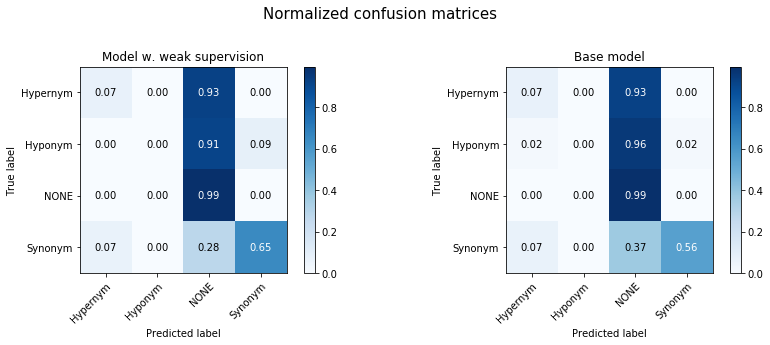

In [21]:
# Confusion matrix
import seaborn as sns
sns.reset_orig() #seaborn changes matplotlib default settings. 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,3.8))

fig.suptitle('Normalized confusion matrices',y=1.1,fontsize = 15)
ax1 = plot_confusion_matrix(y_true, y_weak, n_labels=None,normalize=True,ax = ax1)
ax1.set(title = 'Model w. weak supervision')
ax2 = plot_confusion_matrix(y_true, y_base, n_labels=None,normalize=True, ax = ax2)
ax2.set(title = 'Base model')
plt.show()

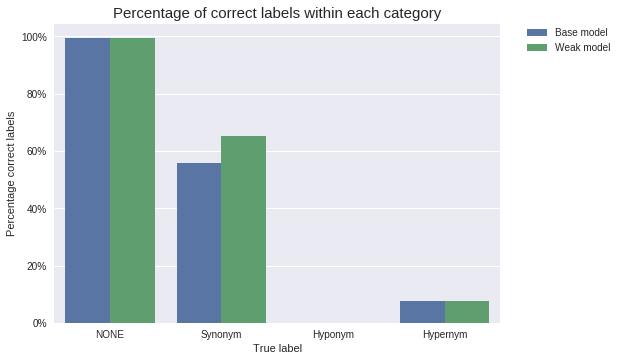

In [24]:
### Plot seaborn with labels
_ = plot_correct_labels(df_err_an)
plt.show()

In [48]:
## Examples...
df_err_an[(df_err_an['True label'] == 'Hypernym') & (df_err_an['Weak learning label'] != 'Hypernym')][50:100]

,file,Sentence between entities,Entity 1,Entity 2,True label,Base label,Weak learning label
2165,S0079642514000784,"surface modifications, such as doping",surface modifications,doping,Hypernym,NONE,NONE
2166,S0079642514000784,"surface modifications, such as doping, functio...",surface modifications,functionalization,Hypernym,NONE,NONE
2167,S0079642514000784,"surface modifications, such as doping, functio...",surface modifications,improving the pore structure and specific surf...,Hypernym,NONE,NONE
2185,S0254058415300766,magnetic dopant such as transition metal,magnetic dopant,transition metal,Hypernym,NONE,NONE
2210,S0254058415300766,"host material such as, ZnS",host material,ZnS,Hypernym,NONE,NONE
2211,S0254058415300766,"host material such as, ZnS, CdS",host material,CdS,Hypernym,NONE,NONE
2212,S0254058415300766,"host material such as, ZnS, CdS, GaN",host material,GaN,Hypernym,NONE,NONE
2215,S0254058415300766,"host material such as, ZnS, CdS, GaN, ZnO, ZnS...",host material,ZnTe,Hypernym,NONE,NONE
2216,S0254058415300766,"host material such as, ZnS, CdS, GaN, ZnO, ZnS...",host material,TiO2,Hypernym,NONE,NONE
2217,S0254058415300766,"host material such as, ZnS, CdS, GaN, ZnO, ZnS...",host material,SnO2,Hypernym,NONE,NONE


In [32]:
df_err_an.loc[201,'Sentence between entities']

'n-alkanes chains containing multiples of three carbon units can be represented directly: n-C6H14'

In [42]:
txts = np.array([data_m_XY_dev['metadata'][idx][0] for idx in range(len(data_m_XY_dev['data_Y']))])
labels = np.array(data_m_XY_dev['data_Y'])

mask = (txts == 'S0010938X14002157') & (labels == 'Hypernym')
indices = [k for k in range(len(mask)) if mask[k]]

In [43]:
indices

[440, 441, 463, 485, 498]

In [50]:


data_m_XY_dev['data_X'][441]

[[481, '0', '-6', 6, 11, 481],
 [596, '1', '-5', 5, 5, 596],
 [702, '2', '-4', 5, 6, 702],
 [2448, '3', '-3', 5, 6, 2448],
 [3910, '4', '-2', 5, 6, 1443],
 [1716, '5', '-1', 5, 15, 1716],
 [1277, '6', '0', 6, 5, 3074],
 [2634, '7', '0', 8, 3, 2634],
 [2850, '8', '0', 8, 6, 2850],
 [3370, '9', '0', 8, 3, 3370],
 [1, '10', '0', 8, 5, 1]]

## <font color='red'>Assessment 3</font>: Assess your explanation (20 pts)

We will mark the explanation along the following dimension: 

* Substance (20pts: well-designed error analysis, correctly explained reasons for performance differences between models)